In [2]:
import os
import random
import numpy as np
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms.functional as TF
from torchvision.transforms import Resize
import torch.nn.functional as F
from monai.losses.dice import DiceLoss

# Path to your data folder
DATA_PATH = "/home/anastasiasinger/Downloads/data_an_et_al_2022/data_repository/data_charite"

# --- Dataset helper ---
def get_valid_subjects(data_path):
    subjects = []
    for subject_path in glob(os.path.join(data_path, '*')):
        mask_path = os.path.join(subject_path, 'masklesion_manual.nii')
        t2_path = os.path.join(subject_path, 't2.nii')
        if os.path.exists(mask_path) and os.path.exists(t2_path):
            subjects.append(subject_path)
    print(f"✅ Found {len(subjects)} valid mouse scans.")
    return subjects

# --- Preprocessing functions ---
def load_nifti(path):
    img = nib.load(path).get_fdata()
    return img

def normalize(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    return image

def resize_slice(slice_, size=(256, 256)):
    slice_tensor = torch.tensor(slice_, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    resized = F.interpolate(slice_tensor, size=size, mode='bilinear', align_corners=False)
    return resized.squeeze().numpy()  # back to (H, W)

def extract_slices(image_3d, mask_3d):
    slices_img, slices_mask = [], []
    for i in range(image_3d.shape[2]):
        img_slice = normalize(image_3d[:, :, i])
        mask_slice = mask_3d[:, :, i]

        # Skip empty slices (no lesion)
        if np.sum(mask_slice) == 0:
            continue

        # Resize
        img_slice = resize_slice(img_slice)
        mask_slice = resize_slice(mask_slice)

        slices_img.append(img_slice)
        slices_mask.append(mask_slice)
    return slices_img, slices_mask

# --- PyTorch Dataset ---
class MRIDataset(Dataset):
    def __init__(self, image_slices, mask_slices, augment=False):
        self.image_slices = image_slices
        self.mask_slices = mask_slices
        self.augment = augment

    def __len__(self):
        return len(self.image_slices)

    def __getitem__(self, idx):
        img = self.image_slices[idx]  # (H, W)
        mask = self.mask_slices[idx]  # (H, W)

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.augment:
            if random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                img = TF.rotate(img, angle)
                mask = TF.rotate(mask, angle)

        return img, mask

# --- Split Methods ---
def get_intra_subject_split(subjects):
    all_imgs, all_masks = [], []
    for subject_path in subjects:
        img = load_nifti(os.path.join(subject_path, 't2.nii'))
        mask = load_nifti(os.path.join(subject_path, 'masklesion_manual.nii'))
        slices_img, slices_mask = extract_slices(img, mask)
        all_imgs.extend(slices_img)
        all_masks.extend(slices_mask)

    X_train, X_temp, y_train, y_temp = train_test_split(all_imgs, all_masks, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return MRIDataset(X_train, y_train, augment=True), MRIDataset(X_val, y_val), MRIDataset(X_test, y_test)

def get_inter_subject_split(subjects):
    random.shuffle(subjects)
    n = len(subjects)
    train_subj = subjects[:int(0.8 * n)]
    val_subj = subjects[int(0.8 * n):int(0.9 * n)]
    test_subj = subjects[int(0.9 * n):]

    def extract_all(subj_list):
        imgs, masks = [], []
        for path in subj_list:
            img = load_nifti(os.path.join(path, 't2.nii'))
            mask = load_nifti(os.path.join(path, 'masklesion_manual.nii'))
            i_slices, m_slices = extract_slices(img, mask)
            imgs.extend(i_slices)
            masks.extend(m_slices)
        return imgs, masks

    train_imgs, train_masks = extract_all(train_subj)
    val_imgs, val_masks = extract_all(val_subj)
    test_imgs, test_masks = extract_all(test_subj)

    return MRIDataset(train_imgs, train_masks, augment=True), MRIDataset(val_imgs, val_masks), MRIDataset(test_imgs, test_masks)

# --- Main Execution ---
subjects = get_valid_subjects(DATA_PATH)

# Get dataset splits
intra_train, intra_val, intra_test = get_intra_subject_split(subjects)
inter_train, inter_val, inter_test = get_inter_subject_split(subjects)

# Create loaders
BATCH_SIZE = 8

intra_loader = DataLoader(intra_train, batch_size=BATCH_SIZE, shuffle=True)
inter_loader = DataLoader(inter_train, batch_size=BATCH_SIZE, shuffle=True)

# Test a batch
for imgs, masks in intra_loader:
    print("🧪 Intra-subject batch:", imgs.shape, masks.shape)
    break

for imgs, masks in inter_loader:
    print("🧪 Inter-subject batch:", imgs.shape, masks.shape)
    break


✅ Found 331 valid mouse scans.
🧪 Intra-subject batch: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
🧪 Inter-subject batch: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


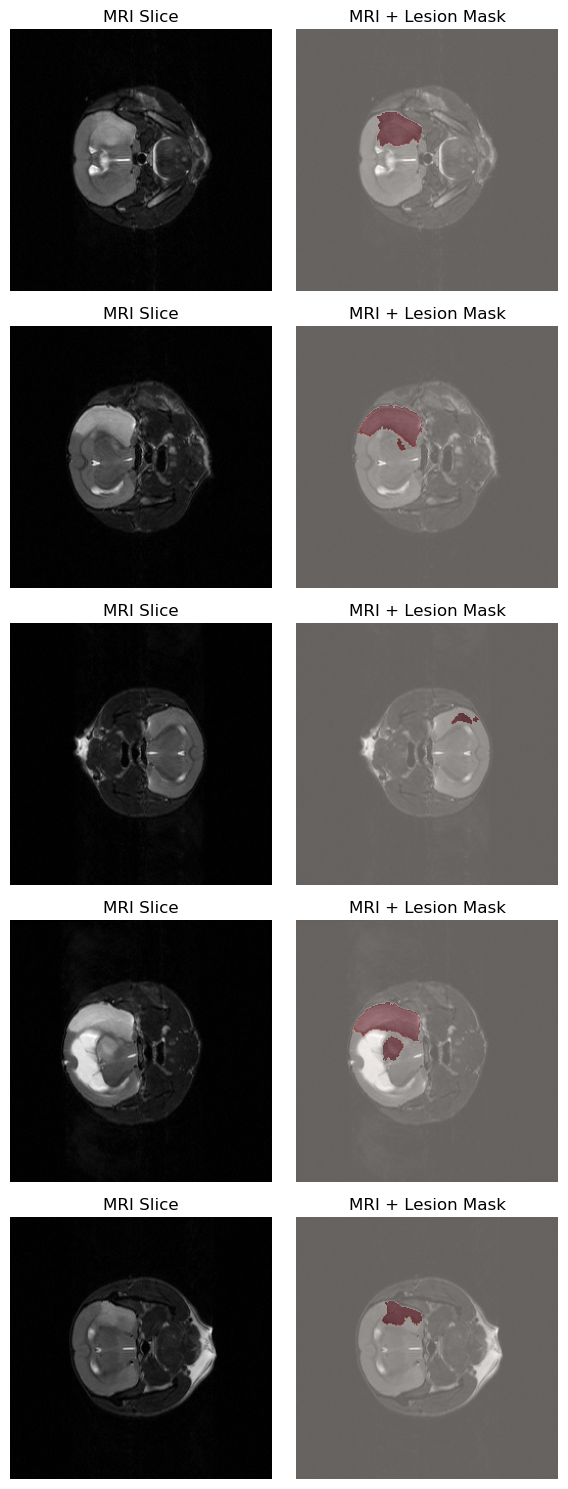

In [2]:
import matplotlib.pyplot as plt

def show_examples(dataset, num=5):
    indices = random.sample(range(len(dataset)), num)
    fig, axs = plt.subplots(num, 2, figsize=(6, 3 * num))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_np = img.squeeze().numpy()
        mask_np = mask.squeeze().numpy()

        axs[i, 0].imshow(img_np, cmap='gray')
        axs[i, 0].set_title("MRI Slice")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(img_np, cmap='gray')
        axs[i, 1].imshow(mask_np, cmap='Reds', alpha=0.4)
        axs[i, 1].set_title("MRI + Lesion Mask")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize examples from training set (e.g. intra-subject)
show_examples(intra_train)


In [3]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# --- U-Net Model ---
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.up2(bottleneck)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))
        return torch.sigmoid(self.final(dec1))


In [4]:
def dice_coef(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    smooth = 1e-6
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    smooth = 1e-6
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


In [5]:
def train_model(model, train_loader, val_loader, device, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_losses = []
    best_dice = 0.0
    criterion=DiceLoss()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, masks = imgs.to(device), masks.to(device)
            # Ensure masks are float and normalized
            masks = masks.float()
            if masks.max() > 1:
                masks = masks / 255.0
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.6f}")

        val_dice, val_iou = evaluate_model(model, val_loader, device)
        print(f"  ✅ Validation Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")
        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), '/home/anastasiasinger/Documents/checkpoint/checkpoint.pth')
            print(f"✅ Saved best model (Dice: {val_dice:.4f}, IoU: {val_iou:.4f})")


    # Plot training loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue', label='Train Loss')
    plt.title('Training Loss Curve (Dice Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def evaluate_model(model, loader, device):
    model.eval()
    dices, ious = [], []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            dices.append(dice_coef(outputs, masks).item())
            ious.append(iou_score(outputs, masks).item())
            

    print(f"  ✅ Validation Dice: {np.mean(dices):.4f} | IoU: {np.mean(ious):.4f}")
    return np.mean(dices), np.mean(ious) 


In [7]:
train_loader = DataLoader(intra_train, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(intra_val, batch_size=8, pin_memory=True, num_workers=2)
test_loader  = DataLoader(intra_test, batch_size=8, pin_memory=True, num_workers=2)


Epoch 1/100: 100%|██████████| 336/336 [01:49<00:00,  3.07it/s]

Epoch 1 - Train Loss: 0.598743


  ✅ Validation Dice: 0.6666 | IoU: 0.5075
✅ Saved best model (Dice: 0.6666, IoU: 0.5075)


Epoch 2/100: 100%|██████████| 336/336 [01:44<00:00,  3.22it/s]

Epoch 2 - Train Loss: 0.388094


  ✅ Validation Dice: 0.7532 | IoU: 0.6081
✅ Saved best model (Dice: 0.7532, IoU: 0.6081)


Epoch 3/100: 100%|██████████| 336/336 [01:44<00:00,  3.20it/s]

Epoch 3 - Train Loss: 0.327923


  ✅ Validation Dice: 0.7599 | IoU: 0.6173
✅ Saved best model (Dice: 0.7599, IoU: 0.6173)


Epoch 4/100: 100%|██████████| 336/336 [01:45<00:00,  3.18it/s]

Epoch 4 - Train Loss: 0.307030


  ✅ Validation Dice: 0.7683 | IoU: 0.6288
✅ Saved best model (Dice: 0.7683, IoU: 0.6288)


Epoch 5/100: 100%|██████████| 336/336 [01:46<00:00,  3.17it/s]

Epoch 5 - Train Loss: 0.292268


  ✅ Validation Dice: 0.8037 | IoU: 0.6752
✅ Saved best model (Dice: 0.8037, IoU: 0.6752)


Epoch 6/100: 100%|██████████| 336/336 [01:46<00:00,  3.17it/s]

Epoch 6 - Train Loss: 0.285306


  ✅ Validation Dice: 0.7759 | IoU: 0.6371


Epoch 7/100: 100%|██████████| 336/336 [01:46<00:00,  3.17it/s]

Epoch 7 - Train Loss: 0.267243


  ✅ Validation Dice: 0.8192 | IoU: 0.6971
✅ Saved best model (Dice: 0.8192, IoU: 0.6971)


Epoch 8/100: 100%|██████████| 336/336 [01:45<00:00,  3.18it/s]

Epoch 8 - Train Loss: 0.260398


  ✅ Validation Dice: 0.8201 | IoU: 0.6987
✅ Saved best model (Dice: 0.8201, IoU: 0.6987)


Epoch 9/100: 100%|██████████| 336/336 [01:45<00:00,  3.18it/s]

Epoch 9 - Train Loss: 0.251624


  ✅ Validation Dice: 0.8123 | IoU: 0.6886


Epoch 10/100: 100%|██████████| 336/336 [01:42<00:00,  3.27it/s]

Epoch 10 - Train Loss: 0.232259


  ✅ Validation Dice: 0.8358 | IoU: 0.7212
✅ Saved best model (Dice: 0.8358, IoU: 0.7212)


Epoch 11/100: 100%|██████████| 336/336 [01:42<00:00,  3.28it/s]

Epoch 11 - Train Loss: 0.221318


  ✅ Validation Dice: 0.8479 | IoU: 0.7406
✅ Saved best model (Dice: 0.8479, IoU: 0.7406)


Epoch 12/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 12 - Train Loss: 0.218954


  ✅ Validation Dice: 0.8222 | IoU: 0.7040


Epoch 13/100: 100%|██████████| 336/336 [01:41<00:00,  3.29it/s]

Epoch 13 - Train Loss: 0.210003


  ✅ Validation Dice: 0.8513 | IoU: 0.7449
✅ Saved best model (Dice: 0.8513, IoU: 0.7449)


Epoch 14/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 14 - Train Loss: 0.206717


  ✅ Validation Dice: 0.8670 | IoU: 0.7684
✅ Saved best model (Dice: 0.8670, IoU: 0.7684)


Epoch 15/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 15 - Train Loss: 0.199307


  ✅ Validation Dice: 0.8553 | IoU: 0.7504


Epoch 16/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 16 - Train Loss: 0.196791


  ✅ Validation Dice: 0.8692 | IoU: 0.7714
✅ Saved best model (Dice: 0.8692, IoU: 0.7714)


Epoch 17/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 17 - Train Loss: 0.184042


  ✅ Validation Dice: 0.8754 | IoU: 0.7815
✅ Saved best model (Dice: 0.8754, IoU: 0.7815)


Epoch 18/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 18 - Train Loss: 0.183628


  ✅ Validation Dice: 0.8803 | IoU: 0.7885
✅ Saved best model (Dice: 0.8803, IoU: 0.7885)


Epoch 19/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 19 - Train Loss: 0.188814


  ✅ Validation Dice: 0.8546 | IoU: 0.7488


Epoch 20/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 20 - Train Loss: 0.178533


  ✅ Validation Dice: 0.8760 | IoU: 0.7818


Epoch 21/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 21 - Train Loss: 0.173799


  ✅ Validation Dice: 0.8714 | IoU: 0.7740


Epoch 22/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 22 - Train Loss: 0.169032


  ✅ Validation Dice: 0.8931 | IoU: 0.8088
✅ Saved best model (Dice: 0.8931, IoU: 0.8088)


Epoch 23/100: 100%|██████████| 336/336 [01:42<00:00,  3.28it/s]

Epoch 23 - Train Loss: 0.167944


  ✅ Validation Dice: 0.8802 | IoU: 0.7890


Epoch 24/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 24 - Train Loss: 0.162880


  ✅ Validation Dice: 0.8870 | IoU: 0.7990


Epoch 25/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 25 - Train Loss: 0.162970


  ✅ Validation Dice: 0.8913 | IoU: 0.8064


Epoch 26/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 26 - Train Loss: 0.159379


  ✅ Validation Dice: 0.8937 | IoU: 0.8100
✅ Saved best model (Dice: 0.8937, IoU: 0.8100)


Epoch 27/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 27 - Train Loss: 0.156139


  ✅ Validation Dice: 0.8918 | IoU: 0.8069


Epoch 28/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 28 - Train Loss: 0.156092


  ✅ Validation Dice: 0.8937 | IoU: 0.8102


Epoch 29/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 29 - Train Loss: 0.152558


  ✅ Validation Dice: 0.8947 | IoU: 0.8116
✅ Saved best model (Dice: 0.8947, IoU: 0.8116)


Epoch 30/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 30 - Train Loss: 0.156765


  ✅ Validation Dice: 0.8945 | IoU: 0.8112


Epoch 31/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 31 - Train Loss: 0.147291


  ✅ Validation Dice: 0.9012 | IoU: 0.8215
✅ Saved best model (Dice: 0.9012, IoU: 0.8215)


Epoch 32/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 32 - Train Loss: 0.147548


  ✅ Validation Dice: 0.8994 | IoU: 0.8190


Epoch 33/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 33 - Train Loss: 0.147380


  ✅ Validation Dice: 0.8859 | IoU: 0.7969


Epoch 34/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 34 - Train Loss: 0.143195


  ✅ Validation Dice: 0.9000 | IoU: 0.8198


Epoch 35/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 35 - Train Loss: 0.138757


  ✅ Validation Dice: 0.9048 | IoU: 0.8278
✅ Saved best model (Dice: 0.9048, IoU: 0.8278)


Epoch 36/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 36 - Train Loss: 0.140221


  ✅ Validation Dice: 0.9014 | IoU: 0.8225


Epoch 37/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 37 - Train Loss: 0.139427


  ✅ Validation Dice: 0.9082 | IoU: 0.8333
✅ Saved best model (Dice: 0.9082, IoU: 0.8333)


Epoch 38/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 38 - Train Loss: 0.144015


  ✅ Validation Dice: 0.9046 | IoU: 0.8278


Epoch 39/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 39 - Train Loss: 0.133890


  ✅ Validation Dice: 0.9092 | IoU: 0.8351
✅ Saved best model (Dice: 0.9092, IoU: 0.8351)


Epoch 40/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 40 - Train Loss: 0.133693


  ✅ Validation Dice: 0.9075 | IoU: 0.8324


Epoch 41/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 41 - Train Loss: 0.130867


  ✅ Validation Dice: 0.9093 | IoU: 0.8348
✅ Saved best model (Dice: 0.9093, IoU: 0.8348)


Epoch 42/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 42 - Train Loss: 0.129966


  ✅ Validation Dice: 0.8933 | IoU: 0.8090


Epoch 43/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 43 - Train Loss: 0.128821


  ✅ Validation Dice: 0.8969 | IoU: 0.8147


Epoch 44/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 44 - Train Loss: 0.126410


  ✅ Validation Dice: 0.9083 | IoU: 0.8336


Epoch 45/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 45 - Train Loss: 0.131147


  ✅ Validation Dice: 0.9043 | IoU: 0.8268


Epoch 46/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 46 - Train Loss: 0.131666


  ✅ Validation Dice: 0.9057 | IoU: 0.8290


Epoch 47/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 47 - Train Loss: 0.123461


  ✅ Validation Dice: 0.8998 | IoU: 0.8198


Epoch 48/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 48 - Train Loss: 0.125485


  ✅ Validation Dice: 0.9076 | IoU: 0.8324


Epoch 49/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 49 - Train Loss: 0.123143


  ✅ Validation Dice: 0.9112 | IoU: 0.8380
✅ Saved best model (Dice: 0.9112, IoU: 0.8380)


Epoch 50/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 50 - Train Loss: 0.122717


  ✅ Validation Dice: 0.9107 | IoU: 0.8374


Epoch 51/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 51 - Train Loss: 0.121392


  ✅ Validation Dice: 0.9150 | IoU: 0.8445
✅ Saved best model (Dice: 0.9150, IoU: 0.8445)


Epoch 52/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 52 - Train Loss: 0.117321


  ✅ Validation Dice: 0.9143 | IoU: 0.8435


Epoch 53/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 53 - Train Loss: 0.119250


  ✅ Validation Dice: 0.9072 | IoU: 0.8323


Epoch 54/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 54 - Train Loss: 0.125046


  ✅ Validation Dice: 0.9138 | IoU: 0.8426


Epoch 55/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 55 - Train Loss: 0.114685


  ✅ Validation Dice: 0.9162 | IoU: 0.8465
✅ Saved best model (Dice: 0.9162, IoU: 0.8465)


Epoch 56/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 56 - Train Loss: 0.113133


  ✅ Validation Dice: 0.9127 | IoU: 0.8409


Epoch 57/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 57 - Train Loss: 0.118283


  ✅ Validation Dice: 0.9121 | IoU: 0.8395


Epoch 58/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 58 - Train Loss: 0.117479


  ✅ Validation Dice: 0.9101 | IoU: 0.8368


Epoch 59/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 59 - Train Loss: 0.111486


  ✅ Validation Dice: 0.8987 | IoU: 0.8180


Epoch 60/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 60 - Train Loss: 0.115396


  ✅ Validation Dice: 0.9117 | IoU: 0.8393


Epoch 61/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 61 - Train Loss: 0.112851


  ✅ Validation Dice: 0.9181 | IoU: 0.8499
✅ Saved best model (Dice: 0.9181, IoU: 0.8499)


Epoch 62/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 62 - Train Loss: 0.116384


  ✅ Validation Dice: 0.9142 | IoU: 0.8434


Epoch 63/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 63 - Train Loss: 0.111820


  ✅ Validation Dice: 0.9179 | IoU: 0.8496


Epoch 64/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 64 - Train Loss: 0.112435


  ✅ Validation Dice: 0.8988 | IoU: 0.8183


Epoch 65/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 65 - Train Loss: 0.107610


  ✅ Validation Dice: 0.9180 | IoU: 0.8496


Epoch 66/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 66 - Train Loss: 0.105900


  ✅ Validation Dice: 0.9106 | IoU: 0.8375


Epoch 67/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 67 - Train Loss: 0.111498


  ✅ Validation Dice: 0.9170 | IoU: 0.8481


Epoch 68/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 68 - Train Loss: 0.107828


  ✅ Validation Dice: 0.9110 | IoU: 0.8380


Epoch 69/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 69 - Train Loss: 0.109120


  ✅ Validation Dice: 0.9139 | IoU: 0.8431


Epoch 70/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 70 - Train Loss: 0.104955


  ✅ Validation Dice: 0.9184 | IoU: 0.8504
✅ Saved best model (Dice: 0.9184, IoU: 0.8504)


Epoch 71/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 71 - Train Loss: 0.103628


  ✅ Validation Dice: 0.9211 | IoU: 0.8549
✅ Saved best model (Dice: 0.9211, IoU: 0.8549)


Epoch 72/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 72 - Train Loss: 0.103949


  ✅ Validation Dice: 0.9153 | IoU: 0.8451


Epoch 73/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 73 - Train Loss: 0.103986


  ✅ Validation Dice: 0.9080 | IoU: 0.8329


Epoch 74/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 74 - Train Loss: 0.103122


  ✅ Validation Dice: 0.9201 | IoU: 0.8533


Epoch 75/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 75 - Train Loss: 0.100566


  ✅ Validation Dice: 0.9209 | IoU: 0.8546


Epoch 76/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 76 - Train Loss: 0.101027


  ✅ Validation Dice: 0.9067 | IoU: 0.8304


Epoch 77/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 77 - Train Loss: 0.103852


  ✅ Validation Dice: 0.9158 | IoU: 0.8461


Epoch 78/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 78 - Train Loss: 0.098568


  ✅ Validation Dice: 0.9203 | IoU: 0.8537


Epoch 79/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 79 - Train Loss: 0.103167


  ✅ Validation Dice: 0.9162 | IoU: 0.8469


Epoch 80/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 80 - Train Loss: 0.101410


  ✅ Validation Dice: 0.9200 | IoU: 0.8530


Epoch 81/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 81 - Train Loss: 0.101259


  ✅ Validation Dice: 0.9201 | IoU: 0.8533


Epoch 82/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 82 - Train Loss: 0.097188


  ✅ Validation Dice: 0.9134 | IoU: 0.8421


Epoch 83/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 83 - Train Loss: 0.097930


  ✅ Validation Dice: 0.9155 | IoU: 0.8454


Epoch 84/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 84 - Train Loss: 0.097178


  ✅ Validation Dice: 0.9238 | IoU: 0.8595
✅ Saved best model (Dice: 0.9238, IoU: 0.8595)


Epoch 85/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 85 - Train Loss: 0.096731


  ✅ Validation Dice: 0.9171 | IoU: 0.8479


Epoch 86/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 86 - Train Loss: 0.098069


  ✅ Validation Dice: 0.9201 | IoU: 0.8534


Epoch 87/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 87 - Train Loss: 0.095113


  ✅ Validation Dice: 0.9112 | IoU: 0.8380


Epoch 88/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 88 - Train Loss: 0.095052


  ✅ Validation Dice: 0.9207 | IoU: 0.8543


Epoch 89/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 89 - Train Loss: 0.094699


  ✅ Validation Dice: 0.9246 | IoU: 0.8608
✅ Saved best model (Dice: 0.9246, IoU: 0.8608)


Epoch 90/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 90 - Train Loss: 0.092164


  ✅ Validation Dice: 0.9232 | IoU: 0.8585


Epoch 91/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 91 - Train Loss: 0.092861


  ✅ Validation Dice: 0.9233 | IoU: 0.8589


Epoch 92/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 92 - Train Loss: 0.092192


  ✅ Validation Dice: 0.9122 | IoU: 0.8402


Epoch 93/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 93 - Train Loss: 0.093656


  ✅ Validation Dice: 0.9193 | IoU: 0.8518


Epoch 94/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 94 - Train Loss: 0.091827


  ✅ Validation Dice: 0.9175 | IoU: 0.8489


Epoch 95/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 95 - Train Loss: 0.089566


  ✅ Validation Dice: 0.9248 | IoU: 0.8613
✅ Saved best model (Dice: 0.9248, IoU: 0.8613)


Epoch 96/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 96 - Train Loss: 0.091003


  ✅ Validation Dice: 0.9090 | IoU: 0.8350


Epoch 97/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 97 - Train Loss: 0.096024


  ✅ Validation Dice: 0.9172 | IoU: 0.8485


Epoch 98/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 98 - Train Loss: 0.087149


  ✅ Validation Dice: 0.9200 | IoU: 0.8531


Epoch 99/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 99 - Train Loss: 0.089782


  ✅ Validation Dice: 0.9239 | IoU: 0.8598


Epoch 100/100: 100%|██████████| 336/336 [01:42<00:00,  3.29it/s]

Epoch 100 - Train Loss: 0.089355


  ✅ Validation Dice: 0.9248 | IoU: 0.8613
✅ Saved best model (Dice: 0.9248, IoU: 0.8613)


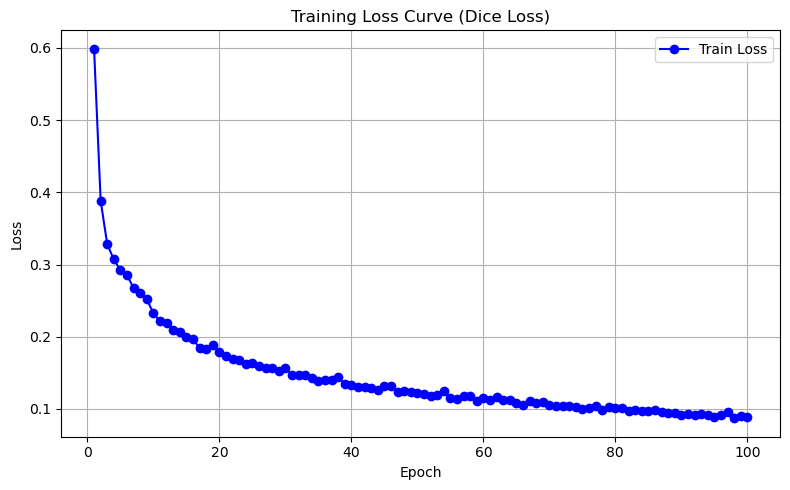

🔍 Final Evaluation on Test Set:


(0.9231198832046154, 0.8586189760718235)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True  

train_loader = DataLoader(intra_train, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(intra_val, batch_size=8, pin_memory=True, num_workers=2)
test_loader  = DataLoader(intra_test, batch_size=8, pin_memory=True, num_workers=2)
model = UNet().to(device)
torch.cuda.empty_cache()
train_model(model, train_loader, val_loader, device, epochs=100) 

print("🔍 Final Evaluation on Test Set:")
evaluate_model(model, test_loader, device)

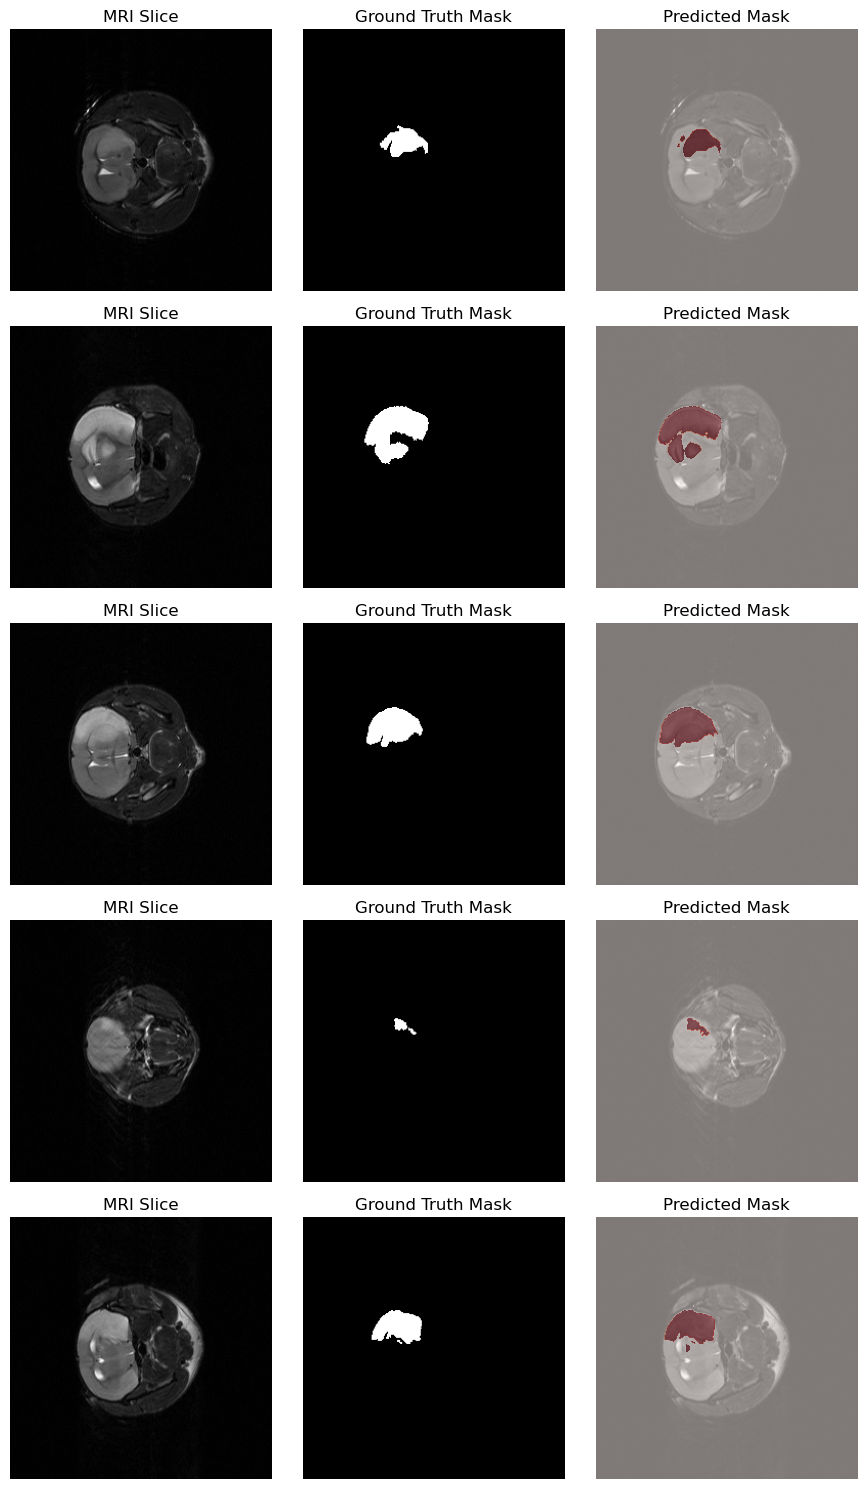

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axs = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)  # Add batch dim

        with torch.no_grad():
            pred = model(img_tensor).squeeze().cpu().numpy()

        # Convert to binary mask
        pred_bin = (pred > 0.5).astype(np.uint8)

        # Convert tensors to numpy for visualization
        img_np = img.squeeze().cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()

        axs[i, 0].imshow(img_np, cmap='gray')
        axs[i, 0].set_title("MRI Slice")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(mask_np, cmap='gray')
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(img_np, cmap='gray')
        axs[i, 2].imshow(pred_bin, cmap='Reds', alpha=0.5)
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call visualization on test set
visualize_predictions(model, intra_test, device)
